# Tutorial 1: **Backward inference learning**
In this notebook, you will learn how to use pcax to do backward inference, that is predicting the inputs given the output.
Since the library is still in its early development, expect major syntax changes. You can keep coming back to this notebook to stay updated.

Good luck!

## Part 0: Importing dependencies

In [1]:
# Core dependencies
import jax
import jax.numpy as jnp
import optax

# pcax
import pcax as px
import pcax.utils as pxu
import pcax.nn as nn

# Environment variables
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Part 1: Defining a Model

In [2]:
class Model(px.EnergyModule):
    def __init__(self, input_dim, hidden_dim, output_dim, act_fn) -> None:
        super().__init__()

        self.act_fn = act_fn

        self.fc_layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        ]

        # We need an extra node to store the input
        self.pc_nodes = [
            px.Node() for _ in range(3)
        ]

        self.pc_nodes[-1].x.frozen = True

    def __call__(self, x, t=None):
        # Save the input
        x = self.pc_nodes[0](x)["x"]

        # Forward pass
        x = self.pc_nodes[1](self.act_fn(self.fc_layers[0](x)))["x"]

        # No activation on the last layer
        x = self.pc_nodes[2](self.fc_layers[1](x))["x"]

        # Save the target, if given
        if t is not None:
            self.pc_nodes[2]["x"] = t

        # Return the output ("u" is equal to "x" if the target is not fixed,
        # while it is the actual output of the model if the target is fixed)
        return self.pc_nodes[2]["u"]

## Part 2: Defining the data

This part is unrelated to pcax. The only highlight is noticing how JAX handles randomness by passing a key around. pcax stores the key internally and allows to access it via a `px.random.RandomKeyGenerator`. We will see later an example of its usage.

In [3]:
from sklearn.datasets import make_moons

def create_data(params, rkey):
    rkey1, rkey2 = jax.random.split(rkey)
    if params["dataset"] == "xor":
        x_dataset = jax.random.randint(rkey1, (params["num_batches"], params["batch_size"], 2), 0, 2)
        y_dataset = ((jnp.sum(x_dataset, axis=-1) % 2)[:, :, None]  == jnp.arange(2)).astype(jnp.float32)
        x_dataset = x_dataset.astype(jnp.float32) + jax.random.normal(rkey2, (params["num_batches"], params["batch_size"], 2)) * params["data_noise"]
    elif params["dataset"] == "two_moons":
        x_dataset, y_dataset = make_moons(n_samples=params["batch_size"], shuffle=True, noise=params["data_noise"], random_state=rkey[0].item())
        y_dataset = jax.numpy.stack([1- y_dataset, y_dataset], axis=1)
        x_dataset, y_dataset = jnp.array(x_dataset), jnp.array(y_dataset).astype(jnp.float32)
        x_dataset, y_dataset = jnp.expand_dims(x_dataset, axis=0), jnp.expand_dims(y_dataset, axis=0)
    else:
        raise NotImplementedError(f"Dataset not implemented: {params['dataset']}")
    return x_dataset, y_dataset

## Part 3: Backward inference
Predictive coding allows us to perform backward inference by fixing the output nodes (i.e., the coordinates of a point) and predicting the input nodes (i.e., its label) that minimise the total energy of the network. To achieve so, we need to modify the inference phase. In fact, the training phase (as it always fixes both input and output nodes) does not differ from normal forward inference training.

The main problem to solve in backward inference is how to initialise the value nodes during inference: since we do not have any input value what should we propagate through the network to get the best performance? This is still an open question. In this tutorial we found that the average input node activation (i.e., the vector [0.5, 0.5]) seems to work quite well, however feel free to experiment around it. The network can be configure to use any constant, random noise, etc. as input value.

In [4]:
params = {
    "dataset": "xor",
    "data_noise": 0.00,
    "num_epochs": 64,
    "hidden_dim": 3,
    "num_batches": 128,
    "batch_size": 4,
    "T": 4,

    "optim_x_l2": 0.0,
    "optim_x_lr": 0.3,
    "optim_w_l2": 0.0,
    "optim_w_lr": 5e-3,
    "optim_w_momentum": 0.9,
    "optim_w_nesterov": True,

    # For the training phase we forward the input values
    "init_train": {
        "init_rand_weight": 0,
        "init_forward_weight": 1.0,
        "init_constant": 0,
        "init_constant_weight": 0,
    },
    # For the test phase we initialize the input values with a constant
    # since we don't have any input values
    "init_test": {
        "init_rand_weight": 0,
        "init_forward_weight": 0,
        "init_constant": 0.5,
        "init_constant_weight": 1.0,
    },

    "logs_plot_kwargs": {},
}

model = Model(2, params["hidden_dim"], 2, jax.nn.tanh)

To avoid any dependencies between the batch_size and the learning rates we sum over the energies of each input sample and divide the `optim_w_lr` by the batch size.

In [5]:
@pxu.vectorize(px.f(px.NodeParam, with_cache=True), in_axis=(0,), out_axis=("sum",))
def loss(x, *, model):
    y = model(x)
    return model.energy()

In [6]:
with pxu.train(model, jax.numpy.zeros((params["batch_size"], 2)), None):
    optim_x = pxu.Optim(
        optax.chain(
            optax.add_decayed_weights(weight_decay=params["optim_x_l2"]),
            optax.sgd(params["optim_x_lr"])
        ),
        model.parameters().filter(px.f(px.NodeParam)(frozen=False))
    )
    optim_w = pxu.Optim(
        optax.chain(
            optax.add_decayed_weights(weight_decay=params["optim_w_l2"]),
            optax.sgd(params["optim_w_lr"] / params["batch_size"], momentum=params["optim_w_momentum"], nesterov=params["optim_w_nesterov"])
        ),
        model.parameters().filter(px.f(px.LayerParam)),
    )

`get_node_initiator` generates the value to pass to `px.init_nodes`.

In [7]:
def get_node_initiator(params):
    def node_initiator(input = None, shape = None, key = None):
        if shape is None:
            shape = input.shape
        if input is None:
            input = jnp.zeros(shape)
        r = jax.random.normal(key, shape) * params["init_rand_weight"]
        d = input * params["init_forward_weight"]
        c = jnp.full(shape, params["init_constant"]) * params["init_constant_weight"]
        return r + d + c
    return node_initiator

Differently from forward inference, we need to perform an iterative phase in order to retrieve the correct value from the input layer (our output). Notice how `y = model.pc0["x"]`, which is the first layer.

In [8]:
import pcax.core as pxc

@pxu.jit()
def free_test_on_batch(t, x, *, model, optim_x, loss, T, init_node):
    forward_value = init_node(t, t.shape, pxc.RKG())
    with pxu.eval(model, forward_value, x):
        for i in range(T):
            with pxu.step(model):
                # Notice how we pass in input model.pc0["x"], in this way
                # the energy of the first layer is 0 and the value nodes are
                # influenced only by the following layers.
                g, (l,) = pxu.grad_and_values(
                    px.f(px.NodeParam)(frozen=False),
                )(loss)(
                    model.pc_nodes[0]["x"],
                    model = model
                )
                
                optim_x(g)
        
        y = model.pc_nodes[0]["x"]
    
    target_class = jnp.argmax(t, axis=1)
    predicted_class = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_class == target_class)

    return accuracy

We use PPC to train the model, that is we update nodes and weights at the same time. This seems to improve performance.

In [9]:
@pxu.jit()
def train_on_batch(t, x, *, model, optim_x, optim_w, loss, T, init_node):
    forward_value = init_node(t, t.shape, pxc.RKG())
    with pxu.train(model, forward_value, x):
        for i in range(T):
            with pxu.step(model):
                g, (l,) = pxu.grad_and_values(
                    px.f(px.NodeParam)(frozen=False) | px.f(px.LayerParam),
                )(loss)(forward_value, model=model)

                optim_x(g)
                optim_w(g)

        y = model.pc_nodes[0]["x"]

    target_class = jnp.argmax(t, axis=1)
    predicted_class = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_class == target_class)

    return accuracy

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def main(params, *, model, optim_x, optim_w) -> None:
    # initialise data
    x_dataset, y_dataset = create_data(params, pxc.RKG())

    # select testing method
    test_on_batch = free_test_on_batch

    train_output_per_epoch = []
    test_output_per_epoch = []

    # these functions are used to initialise the first layer.
    node_init_train = get_node_initiator(params["init_train"])
    node_init_test = get_node_initiator(params["init_test"])

    with tqdm(range(params["num_epochs"]), unit="epoch") as tepoch:
        for epoch in tepoch:
            tepoch.set_description(f"Train Epoch {epoch + 1}")

            # train
            outputs = []
            for (x, y) in zip(x_dataset, y_dataset):
                output = train_on_batch(
                    y, x,
                    model=model,
                    optim_x=optim_x,
                    optim_w=optim_w,
                    loss=loss,
                    T=params["T"],
                    init_node=node_init_train,
                )
                outputs.append(output)

            train_output_per_epoch.append(np.mean(outputs).item())

            # test
            outputs = []
            for (x, y) in zip(x_dataset, y_dataset):
                output = test_on_batch(
                    y, x,
                    model=model,
                    optim_x=optim_x,
                    loss=loss,
                    T=params["T"],
                    init_node=node_init_test,
                )
                outputs.append(output)

            test_output_per_epoch.append(np.mean(outputs).item())

            # todo: add loss, and energy to tqdm bar, add lr_x and lr_w
            tepoch.set_postfix(accuracy=test_output_per_epoch[-1])

    # plot training loss and test accuracy
    plt.clf()
    sns.set_theme()
    if params["dataset"] == "xor":
        fig = sns.lineplot(x=range(params["num_epochs"]), y=np.full_like(range(params["num_epochs"]), 0.75, dtype=float), label="Linear Classifier Accuracy = 0.75", color="red")
    elif params["dataset"] == "two_moons":
        fig = sns.lineplot(x=range(params["num_epochs"]), y=np.full_like(range(params["num_epochs"]), 0.866, dtype=float), label="Linear Classifier Accuracy = 0.866", color="red")
    fig = sns.lineplot(x=range(params["num_epochs"]), y=test_output_per_epoch, label="Test Accuracy", linewidth = 0.5)
    fig.set(ylim=(0, 1.01), title=f"Test Accuracy. Max={max(test_output_per_epoch):.3f} at epoch {test_output_per_epoch.index(max(test_output_per_epoch))}.")
    plt.show()

Train Epoch 64: 100%|██████████| 64/64 [00:46<00:00,  1.38epoch/s, accuracy=0.439]


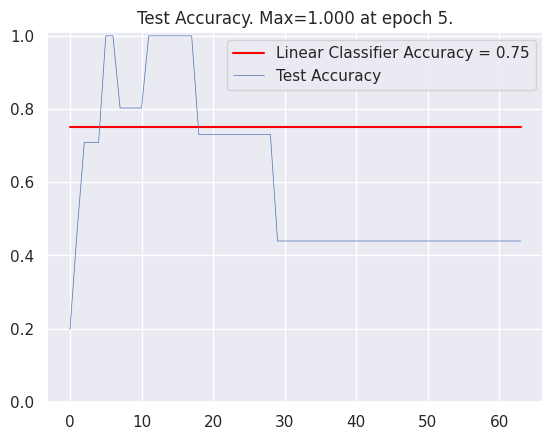

In [11]:
main(params, model=model, optim_x=optim_x, optim_w=optim_w)